# 투자분석 hw3

SIM (Single Index Model)

20249433 최재필

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [3]:
import statsmodels.api as sm

In [4]:
import yfinance as yf

## (a) 

- Choose 4 stocks, each from different industries. 
- Collect 60 monthly returns 
- Collect T bill rates for the same period
- Collect market index returns for the same period
- Run regression model with this data
- Report alpha/beta estimates

### Collect data

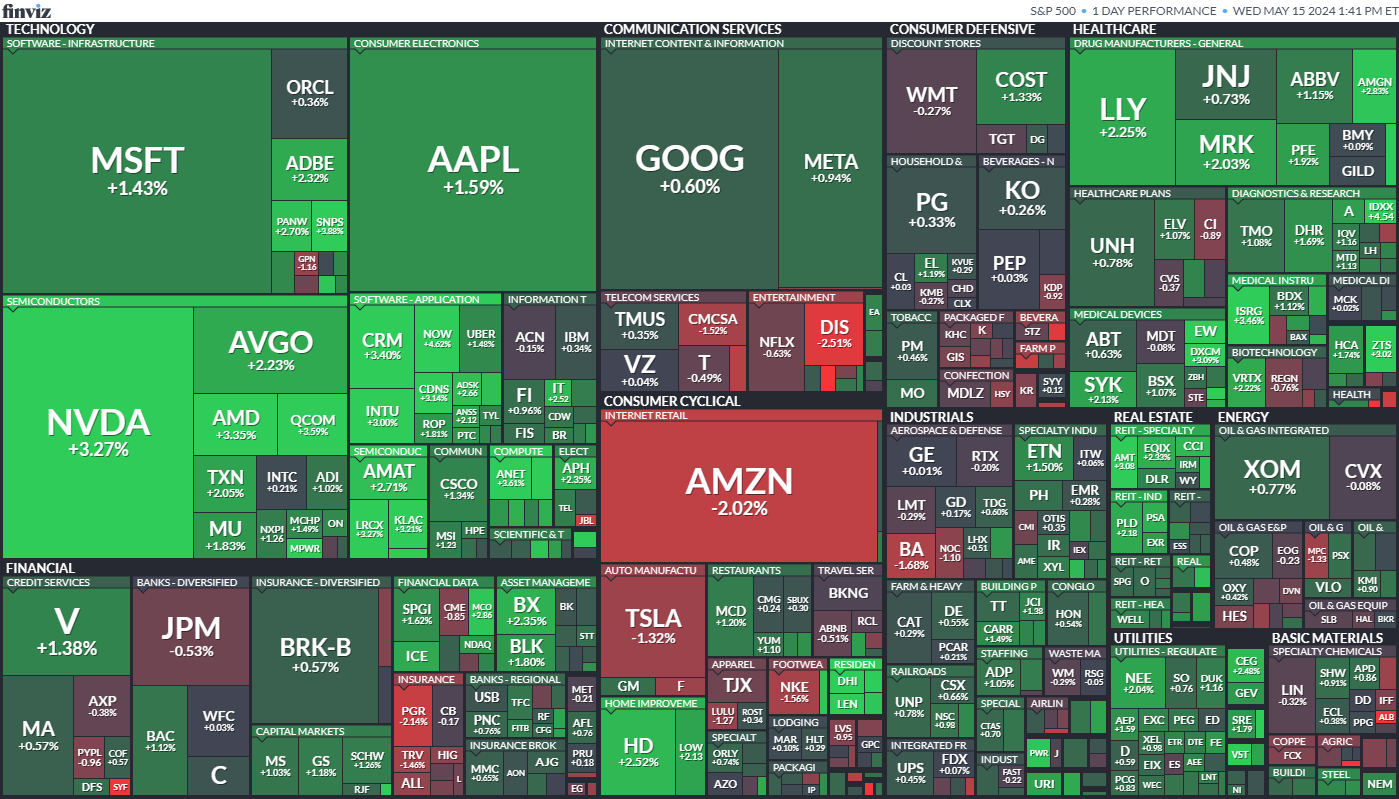

- Stock selection:
    - Technology: AAPL (Apple)
    - Financial: SPGI (S&P Global)
    - Consumer Cyclical: MCD (McDonald's)
    - Consumer Defensive: KO (Coca Cola's)
- Risk-free rate selection:
    - T-bill 3-month
- Market Index Selection:
    - S&P 500 Index: SPY

In [5]:
AAPL = yf.Ticker("AAPL")
SPGI = yf.Ticker("SPGI")
MCD = yf.Ticker("MCD")
KO = yf.Ticker("KO")

SPY = yf.Ticker("SPY")
Tbill3M = yf.Ticker("^IRX")

In [6]:
AAPL_df = AAPL.history(period="5y", interval='1mo')
AAPL_ret = AAPL_df['Close'].pct_change().dropna()
AAPL_ret = AAPL_ret.rename('AAPL')

SPGI_df = SPGI.history(period="5y", interval='1mo')
SPGI_ret = SPGI_df['Close'].pct_change().dropna()
SPGI_ret = SPGI_ret.rename('SPGI')

MCD_df = MCD.history(period="5y", interval='1mo')
MCD_ret = MCD_df['Close'].pct_change().dropna()
MCD_ret = MCD_ret.rename('MCD')

KO_df = KO.history(period="5y", interval='1mo')
KO_ret = KO_df['Close'].pct_change().dropna()
KO_ret = KO_ret.rename('KO')

SPY_df = SPY.history(period="5y", interval='1mo')
SPY_ret = SPY_df['Close'].pct_change().dropna()
SPY_ret = SPY_ret.rename('SPY')

Tbill3M_df = Tbill3M.history(period="5y", interval='1mo') # Annualized return
Tbill3M_ret = Tbill3M_df['Close']
Tbill3M_ret = Tbill3M_ret.rename('Tbill3M')

Tbill3M_ret = Tbill3M_ret / 100 / 12 # Monthly return

In [7]:
AAPL_ret.index = AAPL_ret.index.to_period('M')
SPGI_ret.index = SPGI_ret.index.to_period('M')
MCD_ret.index = MCD_ret.index.to_period('M')
KO_ret.index = KO_ret.index.to_period('M')
SPY_ret.index = SPY_ret.index.to_period('M')

Tbill3M_ret.index = Tbill3M_ret.index.to_period('M')

C:\Users\chlje\AppData\Local\Temp\ipykernel_15028\2982150346.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  AAPL_ret.index = AAPL_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_15028\2982150346.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  SPGI_ret.index = SPGI_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_15028\2982150346.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  MCD_ret.index = MCD_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_15028\2982150346.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  KO_ret.index = KO_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_15028\2982150346.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  SPY_ret.index

In [8]:
len(Tbill3M_df)

60

In [9]:
data_df = pd.concat([AAPL_ret, SPGI_ret, MCD_ret, KO_ret, SPY_ret, Tbill3M_ret], axis=1)
data_df.dropna(inplace=True)

data_df.tail()

,AAPL,SPGI,MCD,KO,SPY,Tbill3M
Date,,,,,,
2024-01,-0.042227,0.017775,-0.012782,0.009503,0.020045,0.004323
2024-02,-0.019794,-0.044541,-0.001503,0.008909,0.052187,0.004353
2024-03,-0.050076,-0.004773,-0.029854,0.019327,0.029503,0.004336
2024-04,-0.006706,-0.022611,-0.031601,0.017720,-0.037338,0.004371
2024-05,0.116054,0.053363,0.001721,0.025093,0.053209,0.004369


In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 59 entries, 2019-07 to 2024-05
Freq: M
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AAPL     59 non-null     float64
 1   SPGI     59 non-null     float64
 2   MCD      59 non-null     float64
 3   KO       59 non-null     float64
 4   SPY      59 non-null     float64
 5   Tbill3M  59 non-null     float64
dtypes: float64(6)
memory usage: 3.2 KB


In [11]:
# Make it excess return
data_df.loc[:, ['AAPL', 'SPGI', 'MCD', 'KO', 'SPY']] = data_df.loc[:, ['AAPL', 'SPGI', 'MCD', 'KO', 'SPY']].subtract(data_df.loc[:, 'Tbill3M'], axis=0)

### Run regression 

In [12]:
stocks = ['AAPL', 'SPGI', 'MCD', 'KO']

def get_SIM_regression(stock_returns, market_returns, print_summary=True):
    X = sm.add_constant(market_returns)
    model = sm.OLS(stock_returns, X)
    results = model.fit()

    if print_summary:
        print(results.summary())

    return results

In [13]:
results = {}

for stock in stocks:
    print(f'SIM regression result of {stock}')
    results[stock] = get_SIM_regression(data_df[stock], data_df['SPY'], print_summary=True)
    print('\n'*5)

SIM regression result of AAPL
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     77.85
Date:                Fri, 17 May 2024   Prob (F-statistic):           3.00e-12
Time:                        17:44:23   Log-Likelihood:                 87.344
No. Observations:                  59   AIC:                            -170.7
Df Residuals:                      57   BIC:                            -166.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0119 

## (b)

- Interpret alpha/beta estimates
- Consider the smallest/largest betas among the four stocks
- To which industries do the two companies belong? 
- Is the business consistent with the estimated beta for the two companies?

In [14]:
estimates = [(stock, results[stock].params.values) for stock in stocks]

In [15]:
sorted(estimates, key=lambda x: x[1][1]) # ticker, alpha, beta / Sort by beta

[('KO', array([-0.0006447 ,  0.60632346])),
 ('MCD', array([-0.00160825,  0.7125231 ])),
 ('SPGI', array([2.24907604e-04, 1.14294700e+00])),
 ('AAPL', array([0.0119366 , 1.21467908]))]

- Lowest beta: KO / Consumer Defensive
- Largest beta: AAPL / Tech

It is consistent with the economic rationale. 

The betas are also in the reasonable range between 0 ~ 2

## (c)

- Use the first 30 months only and run the regression.
- Report the alpha/beta estimates

In [16]:
first30 = data_df.iloc[:30]

first30_results = {}

for stock in stocks:
    first30_results[stock] = get_SIM_regression(first30[stock], first30['SPY'], print_summary=False)

first30_estimates = [(stock, first30_results[stock].params.values) for stock in stocks]

sorted(first30_estimates, key=lambda x: x[1][1]) # ticker, alpha, beta / Sort by beta

[('MCD', array([-0.00208655,  0.74866778])),
 ('KO', array([-0.00746297,  0.92681121])),
 ('SPGI', array([0.00797004, 1.03618267])),
 ('AAPL', array([0.02563887, 1.16642235]))]

## (d)

- Use the latter 30 months only and run the regression.
- Report the alpha/beta estimates

In [17]:
last30 = data_df.iloc[30:]

last30_results = {}

for stock in stocks:
    last30_results[stock] = get_SIM_regression(last30[stock], last30['SPY'], print_summary=False)

last30_estimates = [(stock, last30_results[stock].params.values) for stock in stocks]

sorted(last30_estimates, key=lambda x: x[1][1]) # ticker, alpha, beta / Sort by beta

[('KO', array([0.00120496, 0.31400982])),
 ('MCD', array([-0.00169515,  0.67796934])),
 ('AAPL', array([-0.00122817,  1.18950638])),
 ('SPGI', array([-0.00595599,  1.21044834]))]

## (e)

- Are the three set of estimates (all/first/latter) identical? 
- Discuss the result of a), c) and d)

In [32]:
def plot_first_and_last(stock_ticker):
    # Predicting the lines
    first30_line = first30_results[stock_ticker].predict(sm.add_constant(first30['SPY']))
    last30_line = last30_results[stock_ticker].predict(sm.add_constant(last30['SPY']))

    plt.figure(figsize=(12, 8))
    
    # Scatter and plot for first 30 months
    plt.scatter(first30['SPY'], first30[stock_ticker], color='blue', alpha=0.5, label=f'{stock_ticker} First 30 months')
    plt.plot(first30['SPY'], first30_line, color='blue', linewidth=2, label='First 30 months OLS Line')
    
    # Scatter and plot for last 30 months
    plt.scatter(last30['SPY'], last30[stock_ticker], color='orange', alpha=0.5, label=f'{stock_ticker} Last 30 months')
    plt.plot(last30['SPY'], last30_line, color='orange', linewidth=2, label='Last 30 months OLS Line')
    
    # Labels and legend
    plt.xlabel('Market Return (SPY)')
    plt.ylabel(f'{stock_ticker} Return')
    plt.title(f'{stock_ticker} Return vs Market Return')
    plt.legend()
    plt.show()


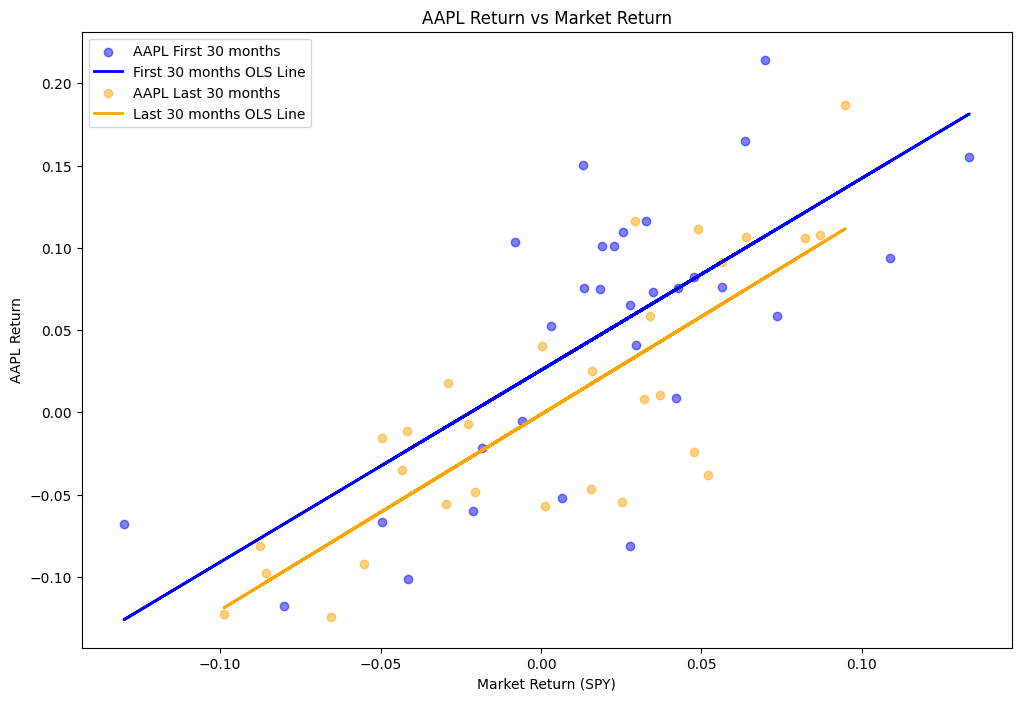

In [33]:
plot_first_and_last('AAPL')

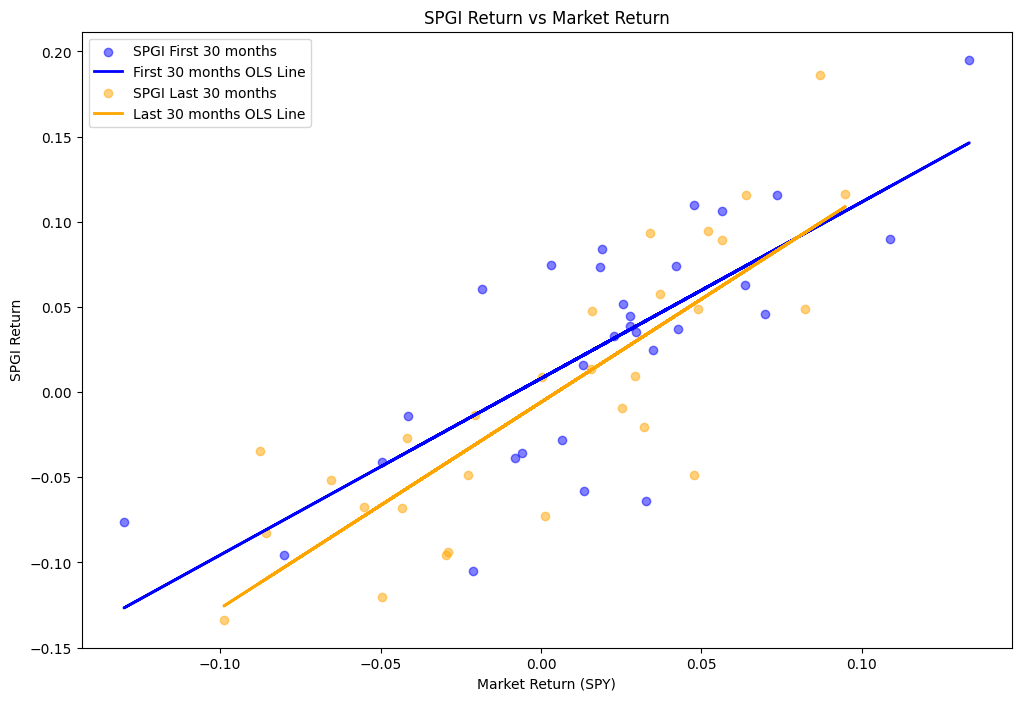

In [34]:
plot_first_and_last('SPGI')

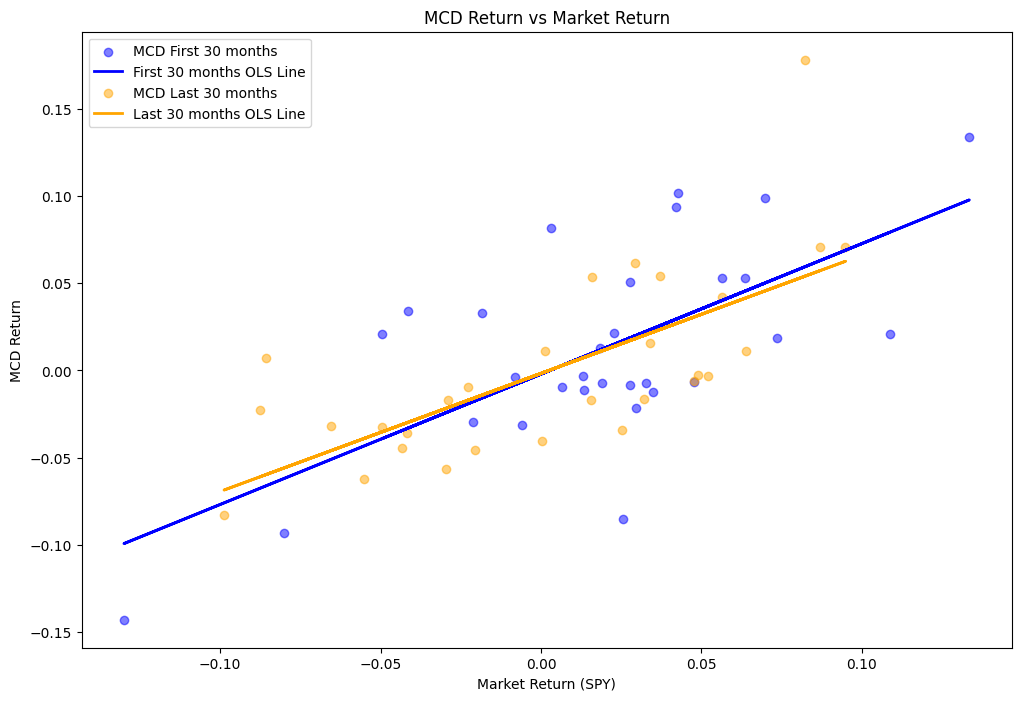

In [35]:
plot_first_and_last('MCD')

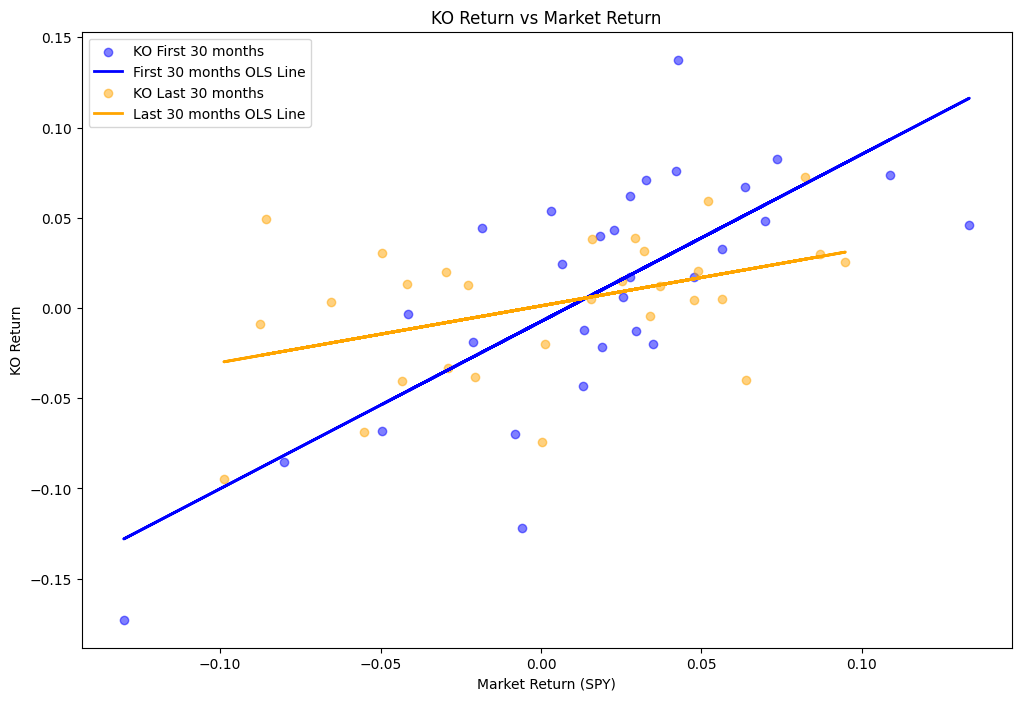

In [37]:
plot_first_and_last('KO')